# Select the best features with Mutual Information
The concept of mutual information was developed by Claude Shannon in the paper "A Mathematical Theory of Communication" from 1949. The term was later coined by Robert Fano. The equation for Mutual Information quantifies how, on average, the change of one variable is related to the change in another. 

$ MI = \sum\limits_{x \in X}\sum\limits_{y \in Y}p(x,y)\log \displaystyle \Bigg[ \frac {p(x,y)} {p(x)p(y)} \Bigg] $

Where p(x) and p(y) are marginal probabilities and p(x,y) is the joint probability. 
When the changes in two variables are related, the MI is positive and greater than zero no matter the direction of the change. In other words, if the two variables are perfectly correlated, the MI will be the same as if the two variables are inversely correlated. When the changes of the two variables are perfectly related, the value of MI is close to 0.5, when one of the two variables never changes or if the two variables are completely independent, the MI will be zero, when the change is related, the MI will be positive and between 0 and 0.5.
Note that the equation that strongly resembles entropy. This is a desirable method to use for machine learning feature selection because it works for both catagorical and continuous features and target values.

In the case of this analysis, the features are continuous and the target values are two discrete variables (zero and one) to represent the two classes. A histrogram is created of the continuous values to create discrete categories. The discrete categories are used to calculate the joint and marginal probabilities. 

An instance of the Scikit Learn class sklearn.feature_selection.mutual_info_classif will be used to estimate the MI for each of the continuous features. The n_neighbors argument controls the number of neighbours to use for the MI estimation for continuous variables.

In [1]:
import stats
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import imblearn

/Users/jmceachern/miniconda3/envs/lightningwrf/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
training_dates = [('2024','06','05'),('2024','06','06'),('2024','06','07'),('2024','06','09'),('2024','06','10'),('2024','06','11'),('2024','06','12'),('2024','06','13'),('2024','06','14'),('2024','06','15'),('2024','06','16'),('2024','06','18'),('2024','06','19'),('2024','06','20'),('2024','06','21'),('2024','07','14'),('2024','07','15'),('2024','07','16'),('2024','07','17'),('2024','07','19'),('2024','07','20'),('2024','07','21'),('2024','07','22'),('2024','07','23'),('2024','07','24'),('2024','07','25'),('2024','07','26'),('2024','07','27')]
feature_lis = ['time','pw','cape','cin','LCL','PBLH','td_2','T2','td_dep','slp','low_cld','mid_cld','shear_1','ctt','RH','mdbz','K','TT','SWI','LI','Qi','Qs','Qg','G50','G70','G100','D57','D510','D710','SI','wmax']
shape = (417, 627)

In [4]:
MI_arr = np.zeros((len(training_dates),len(feature_lis)))

i=0
for date in training_dates:
    print(date)

    # retreive data
    y_train, X_train = stats.retreive_X_y_train([date],feature_lis,shape)
    y_train_bi = np.where(y_train>1,1,0)

    # initialize the undersampler with the desired final class ratio 
    undersample = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.5)
    X_u,y_u = undersample.fit_resample(X_train,y_train_bi)

    # calculate the Mutual Information of the class balanced data
    MI = mutual_info_classif(X_u, y_u, n_neighbors=3)
    MI_arr[i,:] = MI
    i+=1

('2024', '06', '05')
('2024', '06', '06')
('2024', '06', '07')
('2024', '06', '09')
('2024', '06', '10')
('2024', '06', '11')
('2024', '06', '12')
('2024', '06', '13')
('2024', '06', '14')
('2024', '06', '15')
('2024', '06', '16')
('2024', '06', '18')
('2024', '06', '19')
('2024', '06', '20')
('2024', '06', '21')
('2024', '07', '14')
('2024', '07', '15')
('2024', '07', '16')
('2024', '07', '17')
('2024', '07', '19')
('2024', '07', '20')
('2024', '07', '21')
('2024', '07', '22')
('2024', '07', '23')
('2024', '07', '24')
('2024', '07', '25')
('2024', '07', '26')
('2024', '07', '27')


In [5]:
MI_mean = np.mean(MI_arr,axis=0)

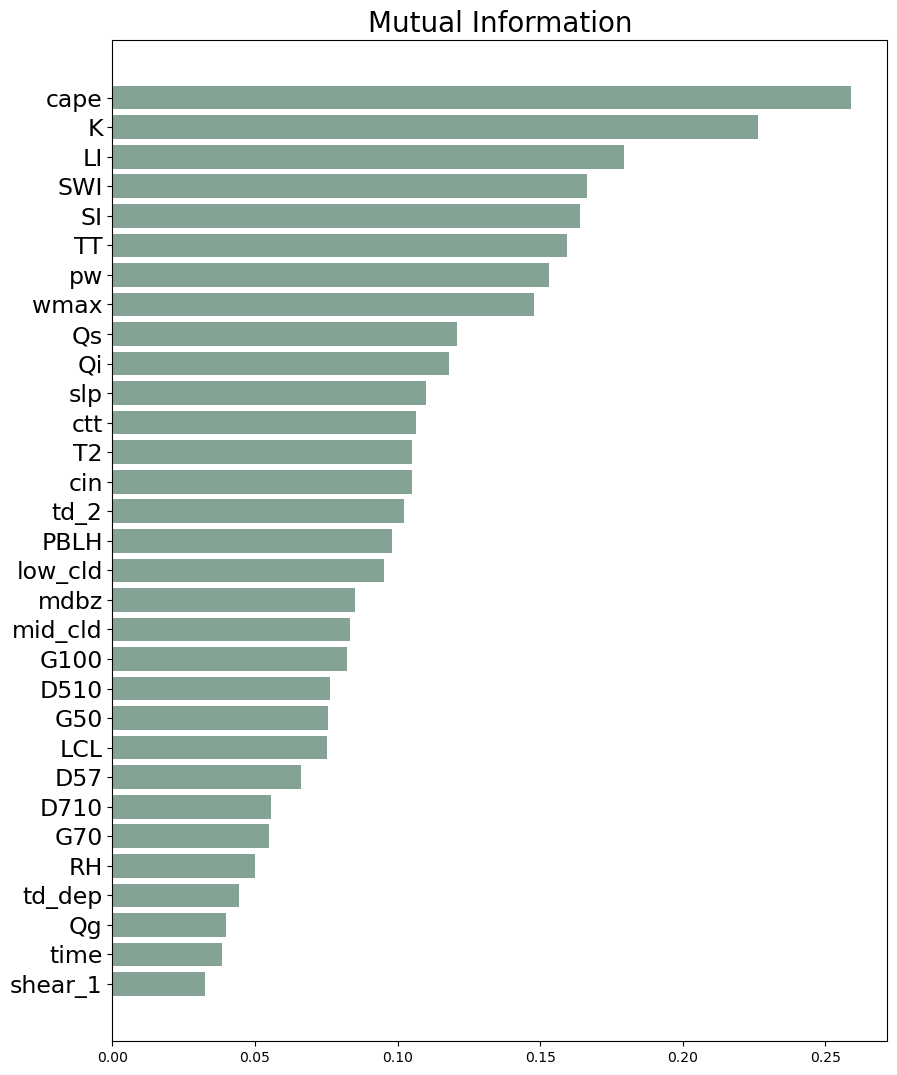

In [10]:
ordered_idx = MI_mean.argsort()
ordered_MI = MI_mean[ordered_idx]

color = (0.2, # redness
        0.4, # greenness
        0.3, # blueness
        0.6 # transparency
        ) 
fig, ax = plt.subplots(figsize=(10, 13))
plt.barh(range(len(ordered_idx)),ordered_MI,color=color)
ax.set_yticks(range(len(ordered_idx)))
_ = ax.set_yticklabels(np.array(feature_lis)[ordered_idx], fontsize=17)
plt.title("Mutual Information", fontsize=20)
plt.savefig('figures/MutualInformation.png')

# Analyse the 12 features with the highest MI

Of the top 12 features, I want to see if any of them are very correlated to each other. If they are very correlated to each other, then training on two very similar features would not add new information to the model, and it would be best to choose a differdnt feature to train on. I will select the X features with the highest MI then create a figure that shows scatter plots of how each feature correlates to the other features. I will randomly select 1000 samples of the large training dataset then see the correlation. I could calculate the correlation coefficient by taking many samples then taking the average. I could also just make a figure of many different class 0 and class 1 histograms. 

In [11]:
training_dates = [('2024','06','05'),('2024','06','12'),('2024','06','19'),('2024','07','14'),('2024','07','23')]
y_train_all, X_train_all = stats.retreive_X_y_train(training_dates,feature_lis,shape)
y_train_bi = np.where(y_train_all>1,1,0)

In [12]:
y_train_bi.shape[0]

22162440

Randomly select N samples.

In [19]:
N = 300 # number of samples
randints = np.random.randint(0, X_train_all.shape[0],N)
X_train = X_train_all[randints,:]
y_train = y_train_bi[randints]

In [20]:
def calc_r(var1,var2):
    var1_mean = np.mean(var1)
    var2_mean = np.mean(var2)
    var1_diff = var1 - var1_mean
    var2_diff = var2 - var2_mean

    r = np.sum(var1_diff*var2_diff) / (np.sum(var1_diff**2) * np.sum(var2_diff**2))**(1/2)
    return r


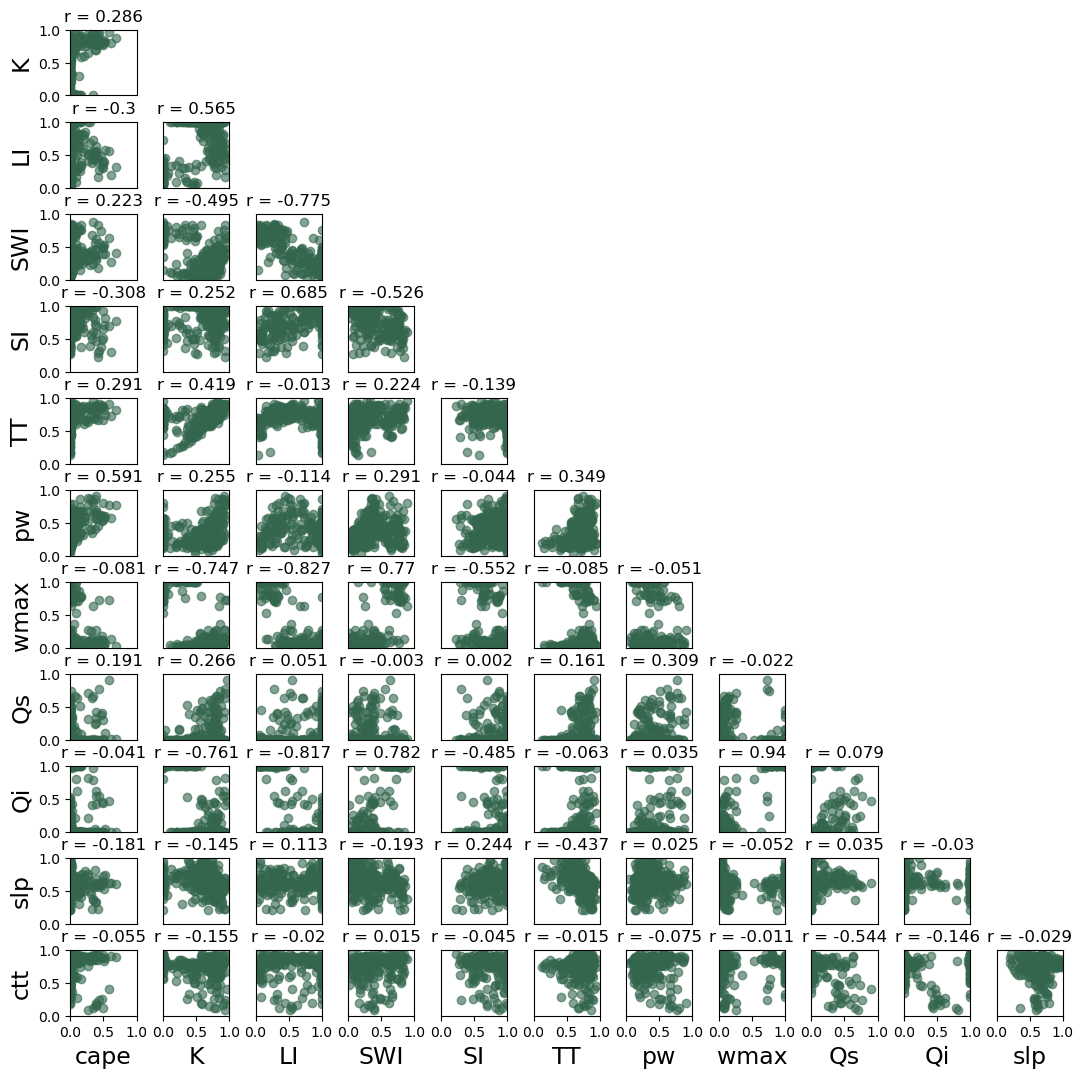

In [21]:
N = 12 # select the N features with the highest MI
X_train_ordered = np.fliplr(X_train[:,ordered_idx])
X_train_best = X_train_ordered[:,0:(N)]

feature_lis_ordered = np.flip(np.array(feature_lis)[ordered_idx])

color = (0.2, # redness
        0.4, # greenness
        0.3, # blueness
        0.6 # transparency
        ) 

fig, axes = plt.subplots(N,N, figsize=(14,14))

for i in range(N):
    for j in range(N):
        if i>j:
            axes[i,j].scatter(X_train_best[:,j],X_train_best[:,i],color=color)
            axes[i,j].set_xlim([0,1])
            axes[i,j].set_ylim([0,1])

            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])

            if i == N-1: # only bottom row
                axes[i,j].set_xlabel(feature_lis_ordered[j], fontsize=17)
                axes[i,j].set_xticks([0,0.5,1])

            if j == 0: # only first column
                axes[i,j].set_ylabel(feature_lis_ordered[i], fontsize=17)
                axes[i,j].set_yticks([0,0.5,1])
            # calculate the Pearsons Correlation
            r = calc_r(X_train_best[:,j],X_train_best[:,i])
            axes[i,j].set_title(f'r = {round(r,3)}')
        else:
            axes[i,j].set_visible(False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)
# fig.suptitle('Correlation Between Features', fontsize=20)
plt.savefig('figures/CorrelationAnalysis.png',bbox_inches='tight')

In [3]:
final_feature_lis = ['pw','cape','cin','T2','slp','ctt','K','SWI','LI','SI','wmax','Q']
y_final, X_final = stats.retreive_X_y_train_small(training_dates,final_feature_lis,shape)

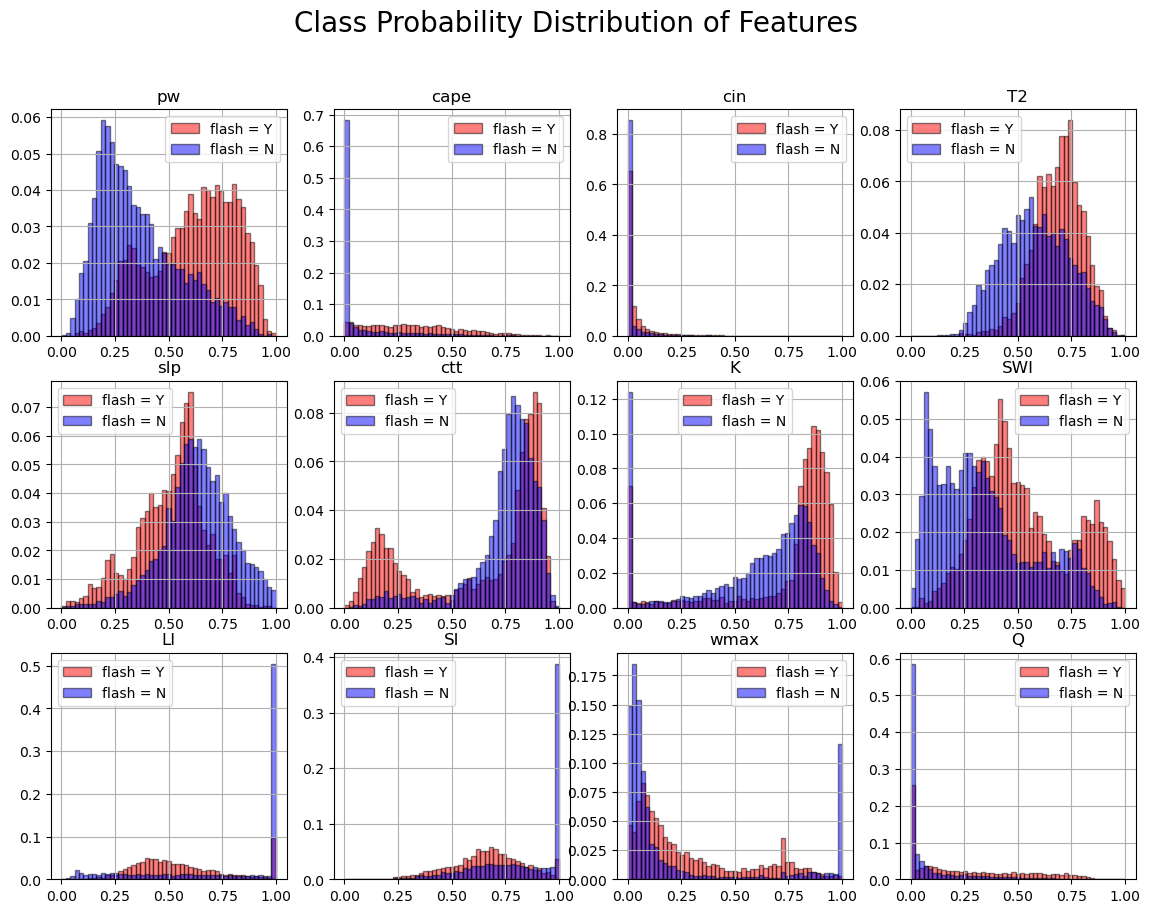

In [6]:
idx_flash = np.where(y_final >= 1)[0]
idx_noflash = np.where(y_final == 0)[0]

# weights (to turn regular histogram into a probability distribution)
n = 5000 # num of samples
weights = np.zeros((n,)) + 1/n

R = 3
C = 4
ni = 0 # counter

fig, axes = plt.subplots(R,C, figsize=(14,10))
N=12
while ni < N:
    for i in range(3):
        for j in range(4):
            
            var_flash = X_final[idx_flash][:,ni]
            var_noflash = X_final[idx_noflash][:,ni]

            sample_flash = np.random.choice(var_flash,size=n)
            sample_noflash = np.random.choice(var_noflash,size=n)

            bins = np.linspace(0,1)

            axes[i,j].hist(sample_flash,weights=weights,bins=bins,alpha=0.5,color='red',zorder=0,label='flash = Y',edgecolor="black")
            axes[i,j].hist(sample_noflash,weights=weights,bins=bins,alpha=0.5,color='blue',zorder=0,label='flash = N',edgecolor="black")
            axes[i,j].set_title(final_feature_lis[ni])
            axes[i,j].grid('on') 
            axes[i,j].legend()

            ni+=1
fig.suptitle('Class Probability Distribution of Features', fontsize=20)
plt.savefig('figures/ProbabilityDistribution.png',bbox_inches='tight')